<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingMAFExtensionGaussianLikelihoodNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['eig']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     / 10.9MB 1.6MB/s


In [0]:
import corner

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

In [0]:
generator_path = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
maf_func_path      = './gdrive/My Drive/MPM/modules/gauss3b/maf-final4layers'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/maf-final/

ls: cannot access './gdrive/My Drive/MPM/modules/gauss3b/maf-final/': No such file or directory


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
#finding EL2O 'by hand'
tf.reset_default_graph()

batch_size    = 256
batch_size_2  = 1
hidden_size   = 10
sample_size_z = 64
sigma_n       = 0.1
n_channels    = 1
num_comp      = 10

maf_size      = [[512, 512], [512, 512], [512, 512], [512, 512]]
maf_prior     = tf.placeholder_with_default(True,shape=[])
true_hess     = tf.placeholder_with_default(True,shape=[])



sample_size_x = tf.placeholder_with_default(10,shape=[])
lr            = tf.placeholder_with_default(0.001,shape=[])

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

generator = hub.Module(generator_path, trainable=False)
encoder   = hub.Module(encoder_path, trainable=False)
#maf_funcs = hub.Module(maf_func_path, trainable=False)

# Define latent space prior
prior             = tfd.MultivariateNormalDiag(loc=tf.zeros([hidden_size]),scale_identity_multiplier=1.0)
log_det_prior     = tf.linalg.logdet(prior.covariance())

# data
# A) training set (used to train maf/should not be corrupted)
x_tr              = tf.placeholder(shape=[batch_size,784,n_channels], dtype=tf.float32)


prior_sample      = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

# this is the noise of the corrupted data
sigma_corr        = tf.placeholder_with_default(np.ones([batch_size_2,784,n_channels], dtype='float32')*sigma_n,shape=[batch_size_2,784,n_channels])


# vae does mean field approximation
encoded_data      = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma         = tf.split(encoded_data, 2, axis=-1)
sigma             = tf.nn.softplus(sigma) + 0.0001
approx_posterior  = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[batch_size,784,n_channels])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
naive_recon       = likelihood_vae.mean()

# test saple from prior
prior_samples     = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_sample),[-1,784,n_channels])
sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()


### ---- training the maf ----- ###

def get_maf():
  
  base_dis = tfd.MultivariateNormalDiag(loc=np.zeros([hidden_size],dtype=np.float32),name="base_dis")
  chain = []
  def get_permutation(name):
    return tf.get_variable(name, initializer=np.random.permutation(hidden_size).astype("int32"), trainable=False)
  
  for i,s in enumerate(maf_size):
    chain.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=s,shift_only=False, name='maf%d'%i)))
    chain.append(tfb.Permute(permutation=get_permutation(name='permutation_%d'%i)))

    maf = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain))
  return maf

def maf_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
    maf_         = get_maf()
    log_prob     = maf_.log_prob(z_sample)
    maf_sample   = maf_.sample(sample_size)
    maf_fwd_pass = maf_.bijector.forward(u_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':maf_sample, 'fwd_pass': maf_fwd_pass})

maf_spec  = hub.create_module_spec(maf_module_spec)
maf_funcs = hub.Module(maf_spec, name='maf_funcs',trainable=True)

maf       = get_maf()
loss      = -tf.reduce_mean(maf.log_prob(approx_posterior.sample()))#maf_funcs({'z_sample':approx_posterior.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op    = optimizer.minimize(loss)

### ---- training the maf ----- ###


### estimate the MAP for ###

# B) corrupted data from test set (networks should not have seen this before)
x_re                 = tf.placeholder(shape=[batch_size_2,784,n_channels], dtype=tf.float32)


#### for naive recon and strating MAP finding at truth

### for corrupted data, we need different batch size:
encoded_data_c    = encoder(tf.reshape(x_re,[-1,28,28,n_channels]))
mu_c, sigma_c     = tf.split(encoded_data_c, 2, axis=-1)

# # coruppted data likelihood
corr_liklogits    = tf.reshape(generator(mu_c),[batch_size_2,784,n_channels])
likelihood_corr   = tfd.Independent(tfd.MultivariateNormalDiag(loc=corr_liklogits,scale_identity_multiplier=sigma_corr))
corr_recon        = likelihood_vae.mean()



MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size_2,hidden_size],dtype=tf.float32),shape=[batch_size_2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = maf_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(maf_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size_2,784,n_channels])

likeli_MAP           = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).log_prob(x_re)

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_MAP

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op2              = optimizer.minimize(loss_MAP, var_list=[MAP])

MAP_mean             = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).mean()


##### do Laplace approximation
ini_val  = np.ones((batch_size_2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)

with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size_2,hidden_size),dtype=np.float32), dtype=np.float32)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus))
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)


update2          = tf.stop_gradient(mu_new.assign(MAP))

# this hessian computation is going to fail -> while loop in maf
# hess             = tf.hessians(-posterior_MAP,MAP)
# hess             = tf.gather(hess, 0)
# hess2            = tf.reduce_sum(hess, axis = 2 )

#constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)


grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

grad_g2          = 0.5*(grad_g2+tf.linalg.transpose(grad_g2))

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size_2],dtype=tf.float32)

hess_approx      = one+grad_g2

sigma_hess       = tf.linalg.inv(hess_approx)

eig1             = tf.linalg.eigvalsh(hess_approx)

sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))

eig2             = tf.linalg.eigvalsh(sigma_hess)

update3          = sigma_new_t2.assign(tf.linalg.cholesky(sigma_hess))

lap_z_samples    = tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size])
lap_liklogits    = tf.reshape(generator(lap_z_samples),[-1,784,n_channels])
lap_likelihood   = tfd.Independent(tfd.Normal(loc=lap_liklogits,scale=sigma_corr))
lap_mean         = lap_likelihood.mean()
lapl_variance_MAP= tf.linalg.diag_part(approx_posterior_laplace.covariance())


# # # construct a GMM approximation from different minima

# with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
#   mu_gmm      = tf.Variable(np.ones((batch_size_2,num_comp,hidden_size)), dtype=np.float32)
#   ini_val2    = np.ones((batch_size_2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
#   sigma_gmm   = tf.constant(ini_val2)
#   sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
#   w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

# mu_est        = tf.placeholder_with_default(tf.zeros([batch_size_2,num_comp,hidden_size]),shape=[batch_size_2,num_comp,hidden_size])
# sigma_est     = tf.placeholder_with_default(tf.ones([batch_size_2,num_comp,hidden_size, hidden_size]),shape=[batch_size_2,num_comp,hidden_size, hidden_size])
# w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

# update_a      = w_gmm.assign(w_est)
# update_b      = mu_gmm.assign(mu_est)
# update_c      = sigma_gmmt.assign(sigma_est)

# gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

# gmm_sample_z  = gmm.sample(sample_size_z)
# #gmm_sample_x  = tfd.Independent(tfd.Normal(loc=tf.reshape(generator(gmm_sample_z),[-1,784,n_channels]),scale=sigma_corr)).mean()

# saver         = tf.train.Saver()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:45:11.878710 140570008405888 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:45:11.964264 140570008405888 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:45:12.085204 140570008405888 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:45:19.626793 140570008405888 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:45:19.712439 140570008405888 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:45:20.273441 140570008405888 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:45:20.424609 140570008405888 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:45:20.505523 140570008405888 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:45:24.111123 140570008405888 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

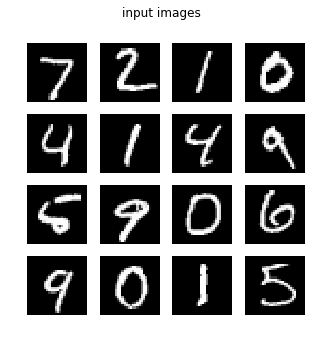

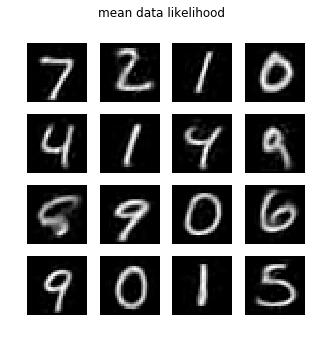

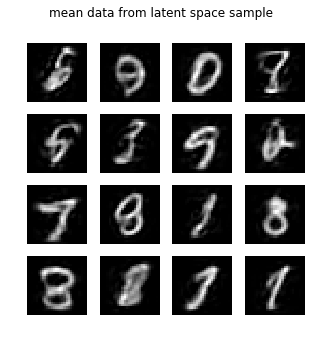

In [0]:
samples = sess.run(prior_samples, feed_dict={x_tr: np.expand_dims(x_truth,-1)})
samples.shape
inim, res, s = sess.run([x_tr,naive_recon, sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_sample: samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(res[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('mean data from latent space sample')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
posterior_loss = []
ii     = 0
nepoch = 0
learning_rate = 1e-3

In [0]:
#train the maf
while nepoch<1000:
  if (ii+1)*batch_size>len(x_train): 
    np.random.shuffle(x_train)
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>100:
    learning_rate=1e-4
  if nepoch>200:
    learning_rate=1e-5
  if nepoch>300:
    learning_rate=1e-8
  x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
  _, ll = sess.run([opt_op,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  posterior_loss+=[ll]
  if ii%500==0:
    print(ll)
  ii+=1

starting epoch 618
8.157178
starting epoch 619
7.643549
starting epoch 620
7.9154854
starting epoch 621
7.482706
starting epoch 622
7.737991
starting epoch 623
7.743252
starting epoch 624
7.568132
starting epoch 625
7.608143
starting epoch 626
7.5806303
starting epoch 627
7.831096
starting epoch 628
7.844276
starting epoch 629
7.6773243
starting epoch 630
8.255894
starting epoch 631
7.6040854
starting epoch 632
7.933153
starting epoch 633
7.785064
starting epoch 634
7.6289263
starting epoch 635
7.2423124
starting epoch 636
7.709455
starting epoch 637
7.721125
starting epoch 638
7.441602
starting epoch 639
8.257782
starting epoch 640
7.7546034
starting epoch 641
7.5185647
starting epoch 642
7.5648994
starting epoch 643
7.7154837
starting epoch 644
7.635214
starting epoch 645
7.6679263
starting epoch 646
7.3249903
starting epoch 647
7.748816
starting epoch 648
7.18091
starting epoch 649
7.9627595
starting epoch 650
7.6075897
starting epoch 651
7.8572006
starting epoch 652
7.217498
starti

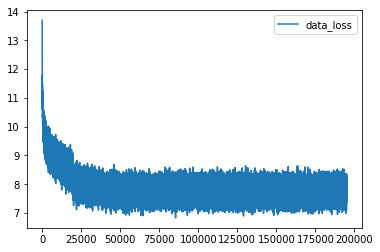

In [0]:
plt.figure()
plot(posterior_loss[::],label='data_loss')
legend()

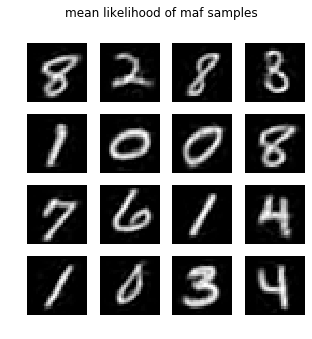

In [0]:
samples1 = sess.run(maf.sample(sample_size_z))

s = sess.run(sample_mean, feed_dict={prior_sample: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#maf_funcs.export(maf_func_path,sess)


In [0]:
maf_s, prior_s = sess.run([maf.sample(10000), prior.sample(10000)])
print(maf_s.shape)

(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


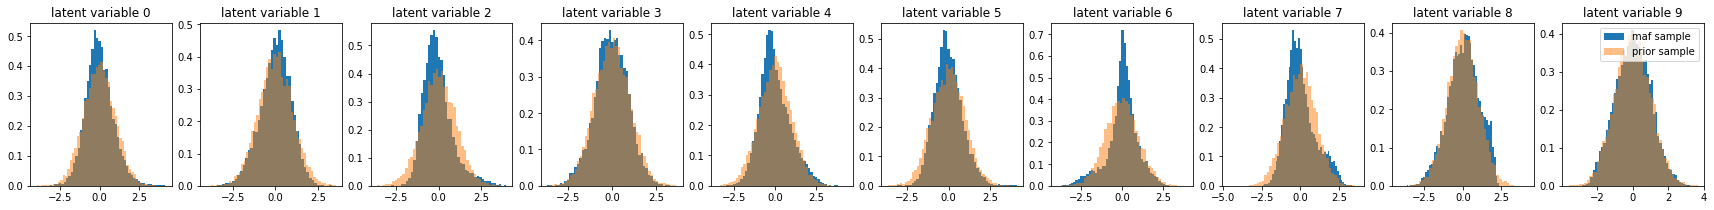

In [0]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

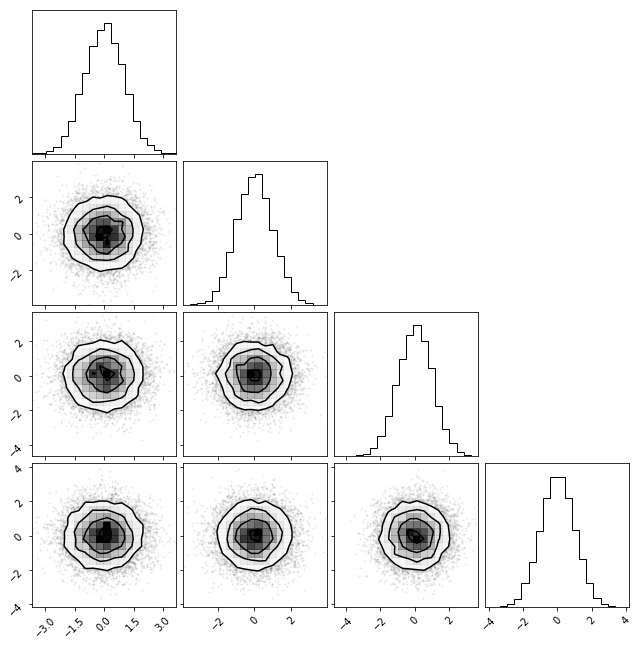

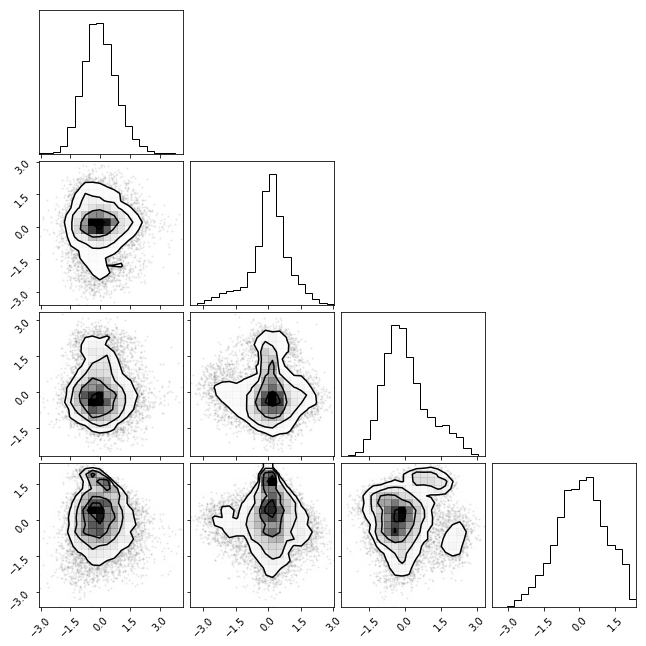

In [0]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])

In [0]:
inc = 6
x_truth   = x_test[inc:batch_size_2+inc]
sigma_new = np.ones([28,28])*sigma_n
sigma_new[0:28,12:18]=1e8
mask=np.ones([28,28])
mask[np.where(sigma_new==1e8)]=0

data        = np.expand_dims(x_truth,-1)
sigma_new   = sigma_new.reshape([batch_size_2,784,n_channels])
mask        = mask.reshape([batch_size_2,784,n_channels])
data        = data*mask

0
4781.9326
3739.9155
3248.88
switching to lr 0.01
2923.8452
2885.0388
switching to lr 0.001
2884.9912
1
4511.7656
2948.986
2935.7217
switching to lr 0.01
2935.7148
2935.717
switching to lr 0.001
2935.7163
2
4738.2563
3576.0469
3535.6848
switching to lr 0.01
3535.6787
3535.6785
switching to lr 0.001
3535.6902
3
7073.4443
3961.7148
3727.888
switching to lr 0.01
3683.542
3656.4395
switching to lr 0.001
3656.4055
4
4471.069
3235.2566
3162.0027
switching to lr 0.01
3159.955
3159.9814
switching to lr 0.001
3159.9578
5
4348.2695
3455.8965
3435.8982
switching to lr 0.01
3435.1448
3435.1462
switching to lr 0.001
3435.145
6
4849.207
3796.3875
3772.5693
switching to lr 0.01
3459.5586
3459.3647
switching to lr 0.001
3459.3962
7
6066.5835
3177.1482
2814.526
switching to lr 0.01
2811.085
2810.9983
switching to lr 0.001
2810.9944
8
4934.8813
3677.0906
3655.8618
switching to lr 0.01
3655.5098
3655.5125
switching to lr 0.001
3655.5105
9
4735.792
4174.67
4137.6606
switching to lr 0.01
4136.917
4136.915

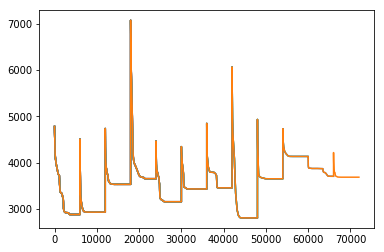

In [0]:
posterior_loss2=[]

l_minima=[]
map_minima=[]
for ii in range(12):
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  elif ii==0:
    #starting from truth
    ini = sess.run([mu_c],feed_dict={x_re: np.expand_dims(x_truth,-1), sigma_corr:sigma_new})[0]
  else:
    ini = np.random.randn((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for ii in range(2000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for ii in range(1000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  plot(posterior_loss2,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new})]

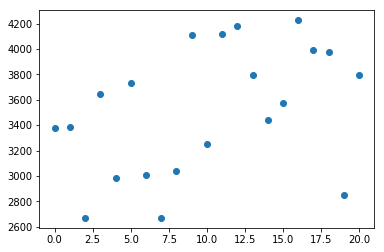

In [0]:
plt.figure()
plt.plot(np.arange(21),l_minima,ls='',marker='o')
plt.show()

In [0]:
import pickle
pickle.dump([l_minima,map_minima],open(minima_path+'maf_minima.pkl','wb'))
l_minima,map_minima = pickle.load(open(minima_path+'maf_minima.pkl','rb'))

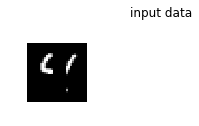

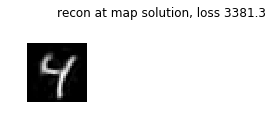

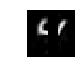

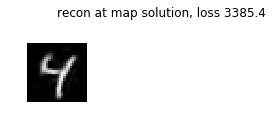

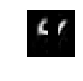

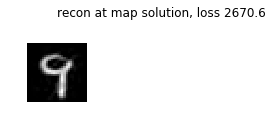

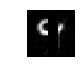

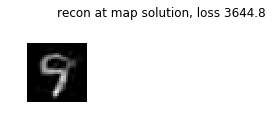

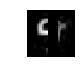

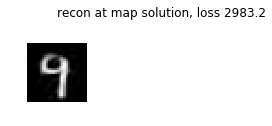

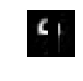

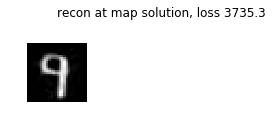

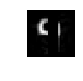

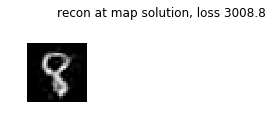

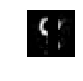

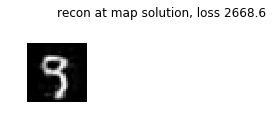

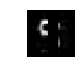

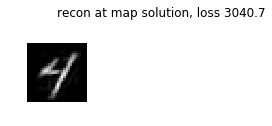

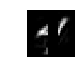

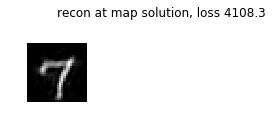

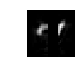

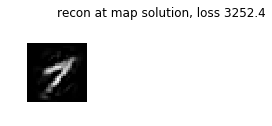

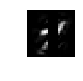

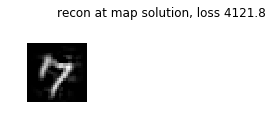

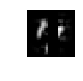

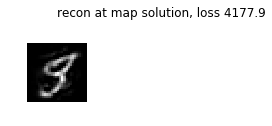

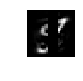

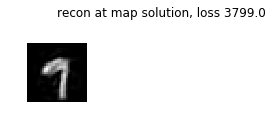

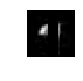

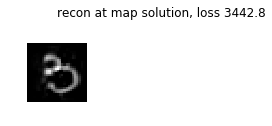

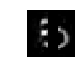

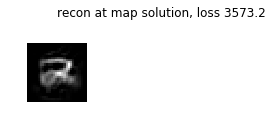

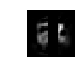

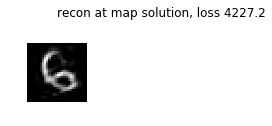

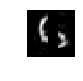

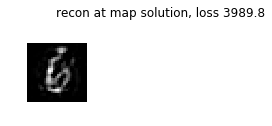

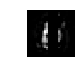

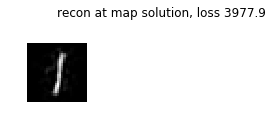

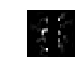

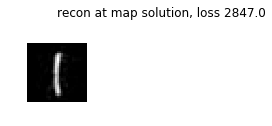

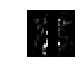

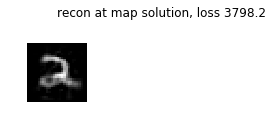

[[9.92772281e-01 9.98098314e-01 9.98862267e-01 9.99775410e-01
  1.00011289e+00 1.00034010e+00 1.00099432e+00 1.00223434e+00
  1.00812650e+00 1.03563856e+06]] [[1.0072803e+00 1.0019053e+00 1.0011390e+00 1.0002246e+00 9.9988711e-01
  9.9966002e-01 9.9900669e-01 9.9777067e-01 9.9193901e-01 9.6558779e-07]] [[8.3446503e-07 9.9257445e-01 9.9822962e-01 9.9910748e-01 9.9951130e-01
  9.9963975e-01 9.9996895e-01 1.0003201e+00 1.0011100e+00 1.0015379e+00]]
[[9.8524648e-01 9.9573094e-01 9.9951291e-01 9.9979627e-01 9.9994415e-01
  1.0000645e+00 1.0005901e+00 1.0012451e+00 1.0155103e+00 9.4296469e+05]] [[1.0149745e+00 1.0042874e+00 1.0004873e+00 1.0002037e+00 1.0000559e+00
  9.9993551e-01 9.9941027e-01 9.9875641e-01 9.8472655e-01 1.0604851e-06]] [[9.5367432e-07 9.9509495e-01 9.9858004e-01 9.9983919e-01 9.9991488e-01
  1.0000422e+00 1.0002939e+00 1.0008738e+00 1.0039474e+00 1.0267090e+00]]
[[8.8286489e-01 9.9758172e-01 9.9863243e-01 9.9988198e-01 1.0000058e+00
  1.0003997e+00 1.0013872e+00 1.0022925e

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[[9.8042744e-01 9.9455798e-01 9.9886292e-01 9.9927163e-01 9.9967742e-01
  9.9998689e-01 1.0012158e+00 1.0016050e+00 1.0100106e+00 1.0528965e+06]] [[1.0199633e+00 1.0054718e+00 1.0011383e+00 1.0007288e+00 1.0003227e+00
  1.0000131e+00 9.9878567e-01 9.9839753e-01 9.9008864e-01 9.4976099e-07]] [[9.5367432e-07 9.9742132e-01 9.9861008e-01 9.9891812e-01 9.9963552e-01
  1.0001483e+00 1.0001836e+00 1.0008229e+00 1.0014347e+00 1.0070075e+00]]
[[9.9861413e-01 9.9950439e-01 9.9998486e-01 9.9999952e-01 9.9999994e-01
  1.0000023e+00 1.0000111e+00 1.0003167e+00 1.0007628e+00 2.5123430e+04]] [[1.0013878e+00 1.0004959e+00 1.0000151e+00 1.0000005e+00 1.0000001e+00
  9.9999774e-01 9.9998891e-01 9.9968338e-01 9.9923778e-01 3.9803483e-05]] [[3.9994717e-05 9.9932551e-01 9.9972135e-01 9.9989647e-01 9.9996150e-01
  9.9999875e-01 9.9999982e-01 1.0000000e+00 1.0000087e+00 1.0000962e+00]]
[[9.2686766e-01 9.9435514e-01 9.9676043e-01 9.9901444e-01 1.0016000e+00
  1.0048583e+00 1.0094920e+00 1.0349268e+00 1.157776

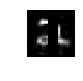

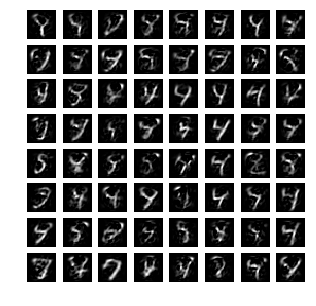

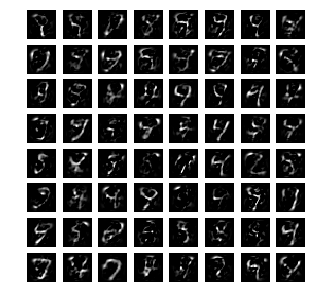

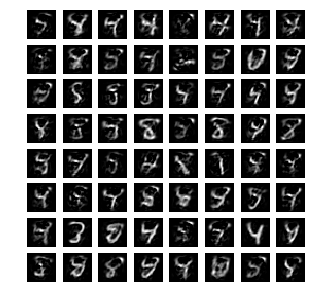

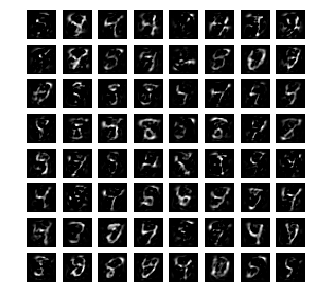

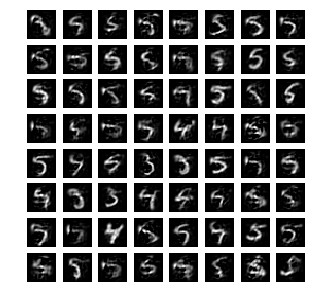

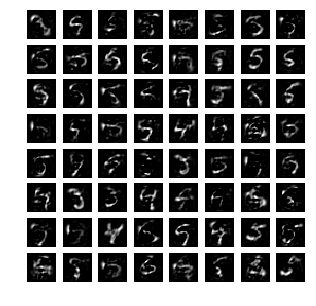

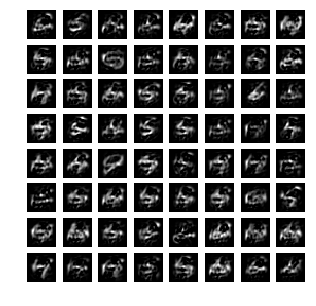

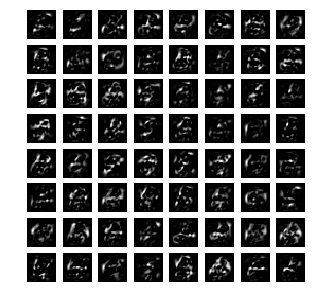

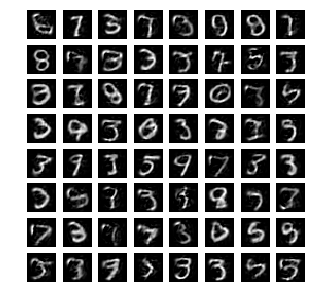

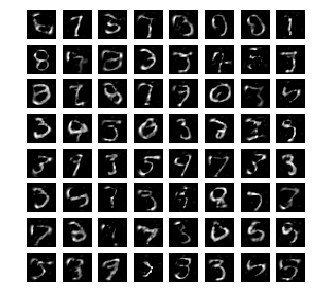

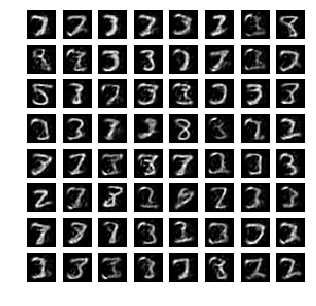

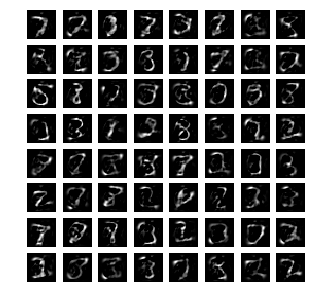

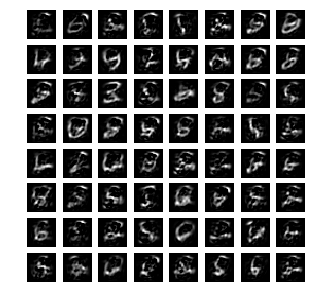

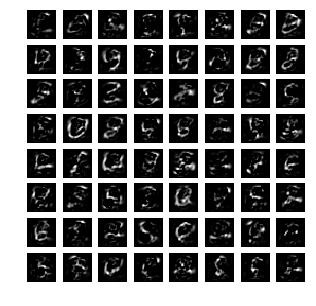

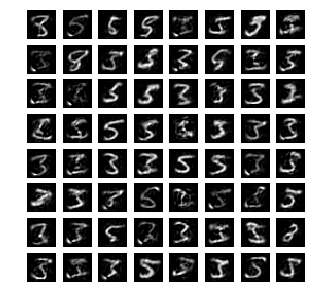

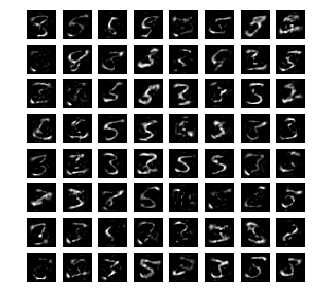

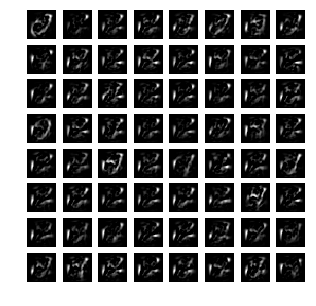

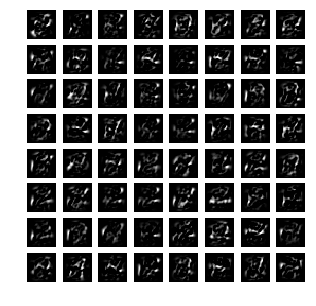

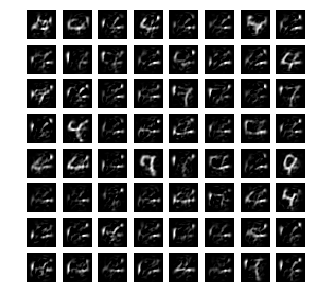

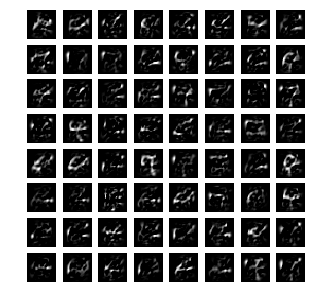

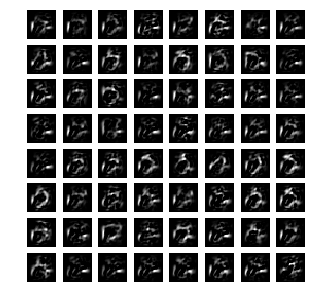

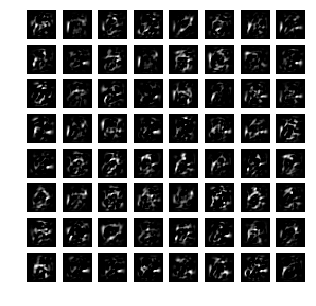

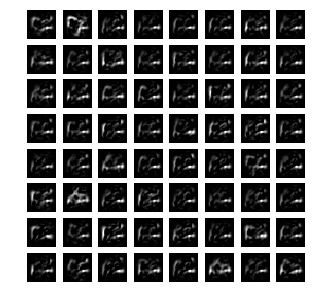

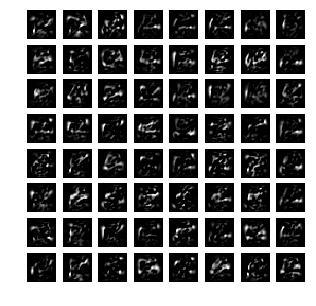

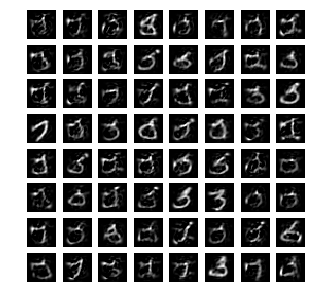

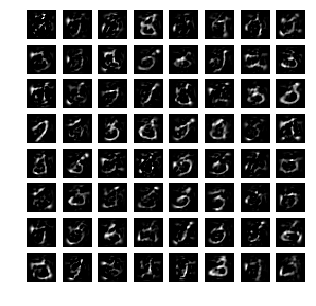

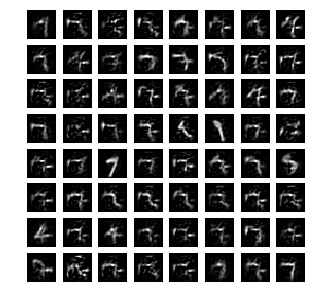

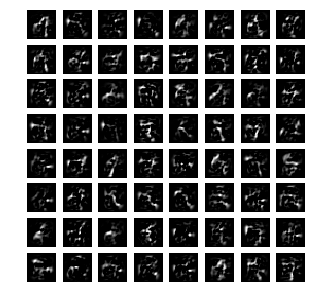

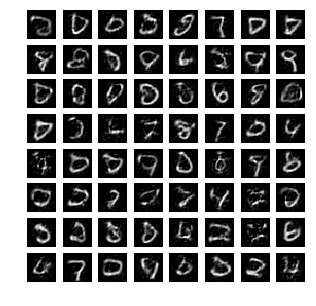

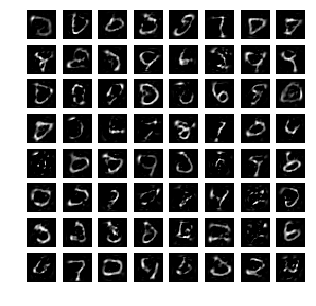

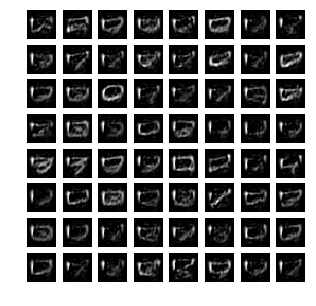

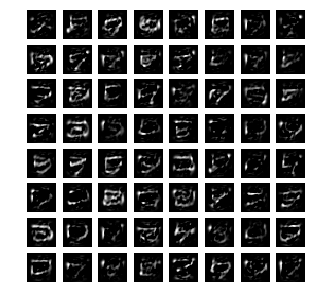

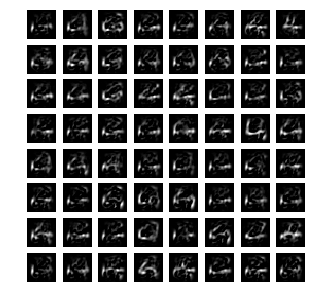

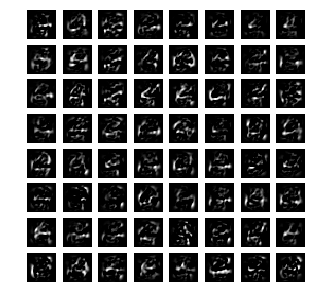

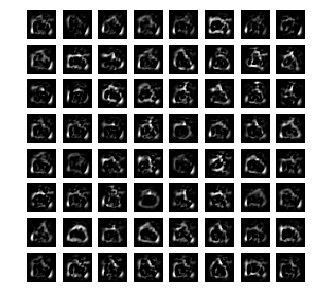

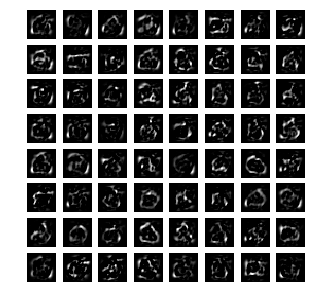

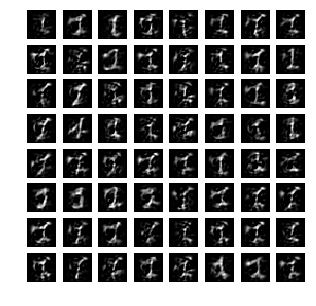

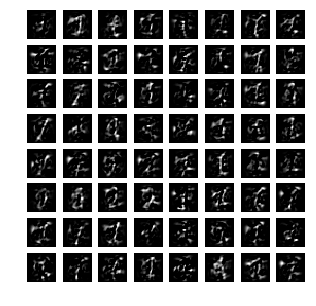

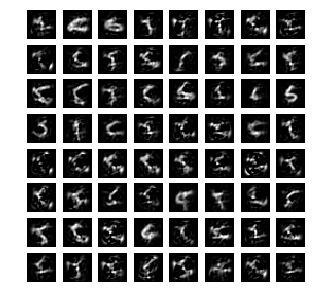

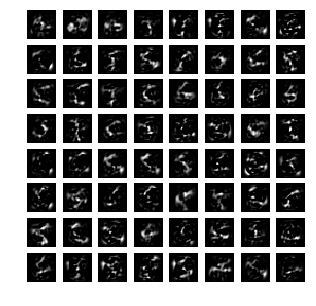

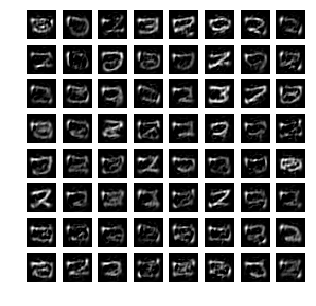

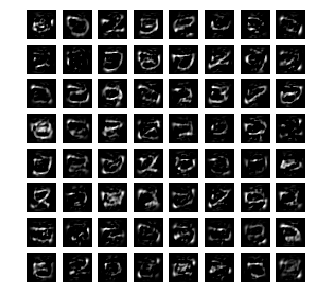

In [0]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')


order = np.argsort(l_minima)
for ii,ini_ in enumerate(map_minima[order]):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask[0,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')


varis=[]  
for ii,ini_ in enumerate(map_minima[order]):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})   
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new})
  eig1_, eig2_ = sess.run([eig1, eig2],feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
  print(eig1_, 1./eig1_, eig2_)
  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})]
  
  z_samples = sess.run(lap_z_samples,feed_dict={x_re: data, sigma_corr:sigma_new})
  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  figure(figsize=(5,5))
  mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
  for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
    axis('off')    

    


(21, 1, 1, 10)


IndexError: ignored

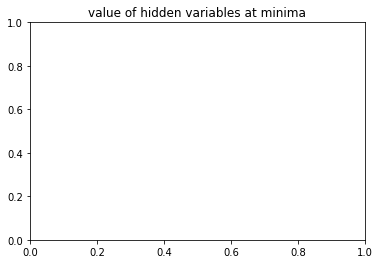

In [0]:
varis=np.asarray(varis)
map_minima=np.asarray(map_minima)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima)):
  print(map_minima.shape)
  yerr_= np.sqrt(varis[ii,0])
  print(len(yerr))
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

0
4290.7666
3970.183
3969.802
3969.7864
3969.7888
3969.7832
3969.7856
3969.781
3969.7974
3969.804
1
5099.7524
3135.977
3045.306
3036.0308
3036.0303
3036.0444
3036.0417
3036.019
3036.02
3036.0432
2
6121.2637
3608.857
3385.7532
3361.5356
3361.4863
3361.499
3361.5012
3361.5063
3361.4915
3361.4949
3
3727.694
3167.003
3166.99
3166.991
3166.9805
3166.9905
3166.9795
3166.9902
3166.998
3166.9858
4
5386.545
3736.0122
3733.8838
3733.7935
3733.8035
3733.818
3733.885
3733.793
3733.9104
3733.9304
5
4808.3022
3030.8179
3011.4495
2918.702
2711.6404
2653.5024
2653.4521
2653.4426
2653.4678
2653.4758
6
5247.2476
4128.208
4124.7
4124.69
4124.703
4124.721
4124.7197
4124.705
4124.705
4124.722
7
4986.698
3485.535
3398.7654
3359.188
3358.3906
3358.3574
3358.361
3358.3674
3358.3638
3358.3577
8
4763.665
3046.2126
2661.7651
2660.038
2658.7883
2658.7878
2658.7898
2658.7935
2658.7908
2658.7947
9
5392.6836
2878.2942
2870.8765
2870.827
2870.8367
2870.82
2870.8394
2870.8413
2870.8464
2870.8186


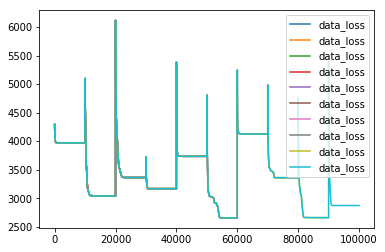

In [0]:
l_minima_old=[]
map_minima_old=[]
posterior_loss3=[]
for ii in range(10):
  print(ii)
  ini = np.random.randn((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, maf_prior: False, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  for ii in range(5000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-4
  for ii in range(2000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  l_minima_old+=[ll]
  map_minima_old+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new, maf_prior: False})]
  plot(posterior_loss3,label='data_loss')
  legend()

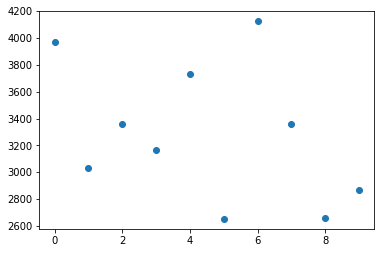

In [0]:
plt.figure()
plt.plot(np.arange(10),l_minima_old,ls='',marker='o')
plt.show()

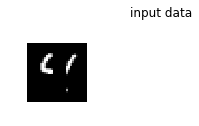

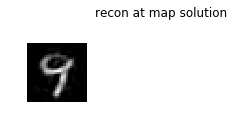

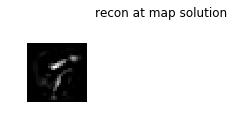

In [0]:
mean_at_map_2 = sess.run(MAP_mean,feed_dict={x_re: data, maf_prior: False, sigma_corr: sigma_new})



figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')

figure(figsize=(5,5))
suptitle('recon at map solution')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean_at_map_2[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
    

figure(figsize=(5,5))
suptitle('recon at map solution')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape((mean_at_map-mean_at_map_2)[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')

In [0]:
for ii,ini_ in enumerate(map_minima_old):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new,maf_prior: False})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima_old[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')


varis=[]
for ii,ini_ in enumerate(map_minima_old):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new,maf_prior: False})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, maf_prior: False})
  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})]
  #print(l_samples.shape)
  figure(figsize=(5,5))
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  figure(figsize=(5,5))   
  mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
  for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
    axis('off')    
    

NameError: ignored

W0503 07:09:13.611931 139770617186176 legend.py:1289] No handles with labels found to put in legend.


(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10


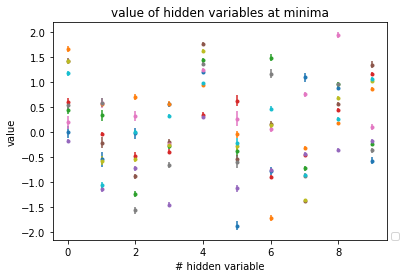

In [0]:
varis=np.asarray(varis)
map_minima_old=np.asarray(map_minima_old)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima_old)):
  print(map_minima_old.shape)
  yerr_= np.sqrt(varis[ii,0])
  print(len(yerr))
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima_old[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()